# Exercise: Determining Minimum Sampling Rate

This notebook solves an exercise to determine the minimum sampling rate for a given signal.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Create output directory for images
output_dir = '../img'
os.makedirs(output_dir, exist_ok=True)


## Signal Analysis

Given signal: $x(t) = \cos(100\pi t) + \sin(200\pi t) + \cos(500\pi t + \pi/4) + 7$

Let's analyze the frequency components:


In [10]:
# Signal components
# x(t) = cos(100πt) + sin(200πt) + cos(500πt + π/4) + 7

# Frequency analysis:
# cos(100πt): frequency = 100π/(2π) = 50 Hz
# sin(200πt): frequency = 200π/(2π) = 100 Hz  
# cos(500πt + π/4): frequency = 500π/(2π) = 250 Hz
# 7: constant (DC component, 0 Hz)

frequencies = [0, 50, 100, 250]  # Hz
f_max = max(frequencies)  # Maximum frequency = 250 Hz
f_nyquist = 2 * f_max  # Nyquist rate = 500 Hz

print(f"Signal components:")
print(f"  - cos(100πt): f = 50 Hz")
print(f"  - sin(200πt): f = 100 Hz")
print(f"  - cos(500πt + π/4): f = 250 Hz")
print(f"  - Constant: f = 0 Hz")
print(f"\nMaximum frequency: f_max = {f_max} Hz")
print(f"Minimum sampling rate (Nyquist rate): f_s = 2f_max = {f_nyquist} Hz")


Signal components:
  - cos(100πt): f = 50 Hz
  - sin(200πt): f = 100 Hz
  - cos(500πt + π/4): f = 250 Hz
  - Constant: f = 0 Hz

Maximum frequency: f_max = 250 Hz
Minimum sampling rate (Nyquist rate): f_s = 2f_max = 500 Hz


## Signal Visualization with Sinc Reconstruction

Let's plot the signal, demonstrate sampling at different rates, and reconstruct using sinc interpolation:


Saved: ../img/aliasing_exercise.png


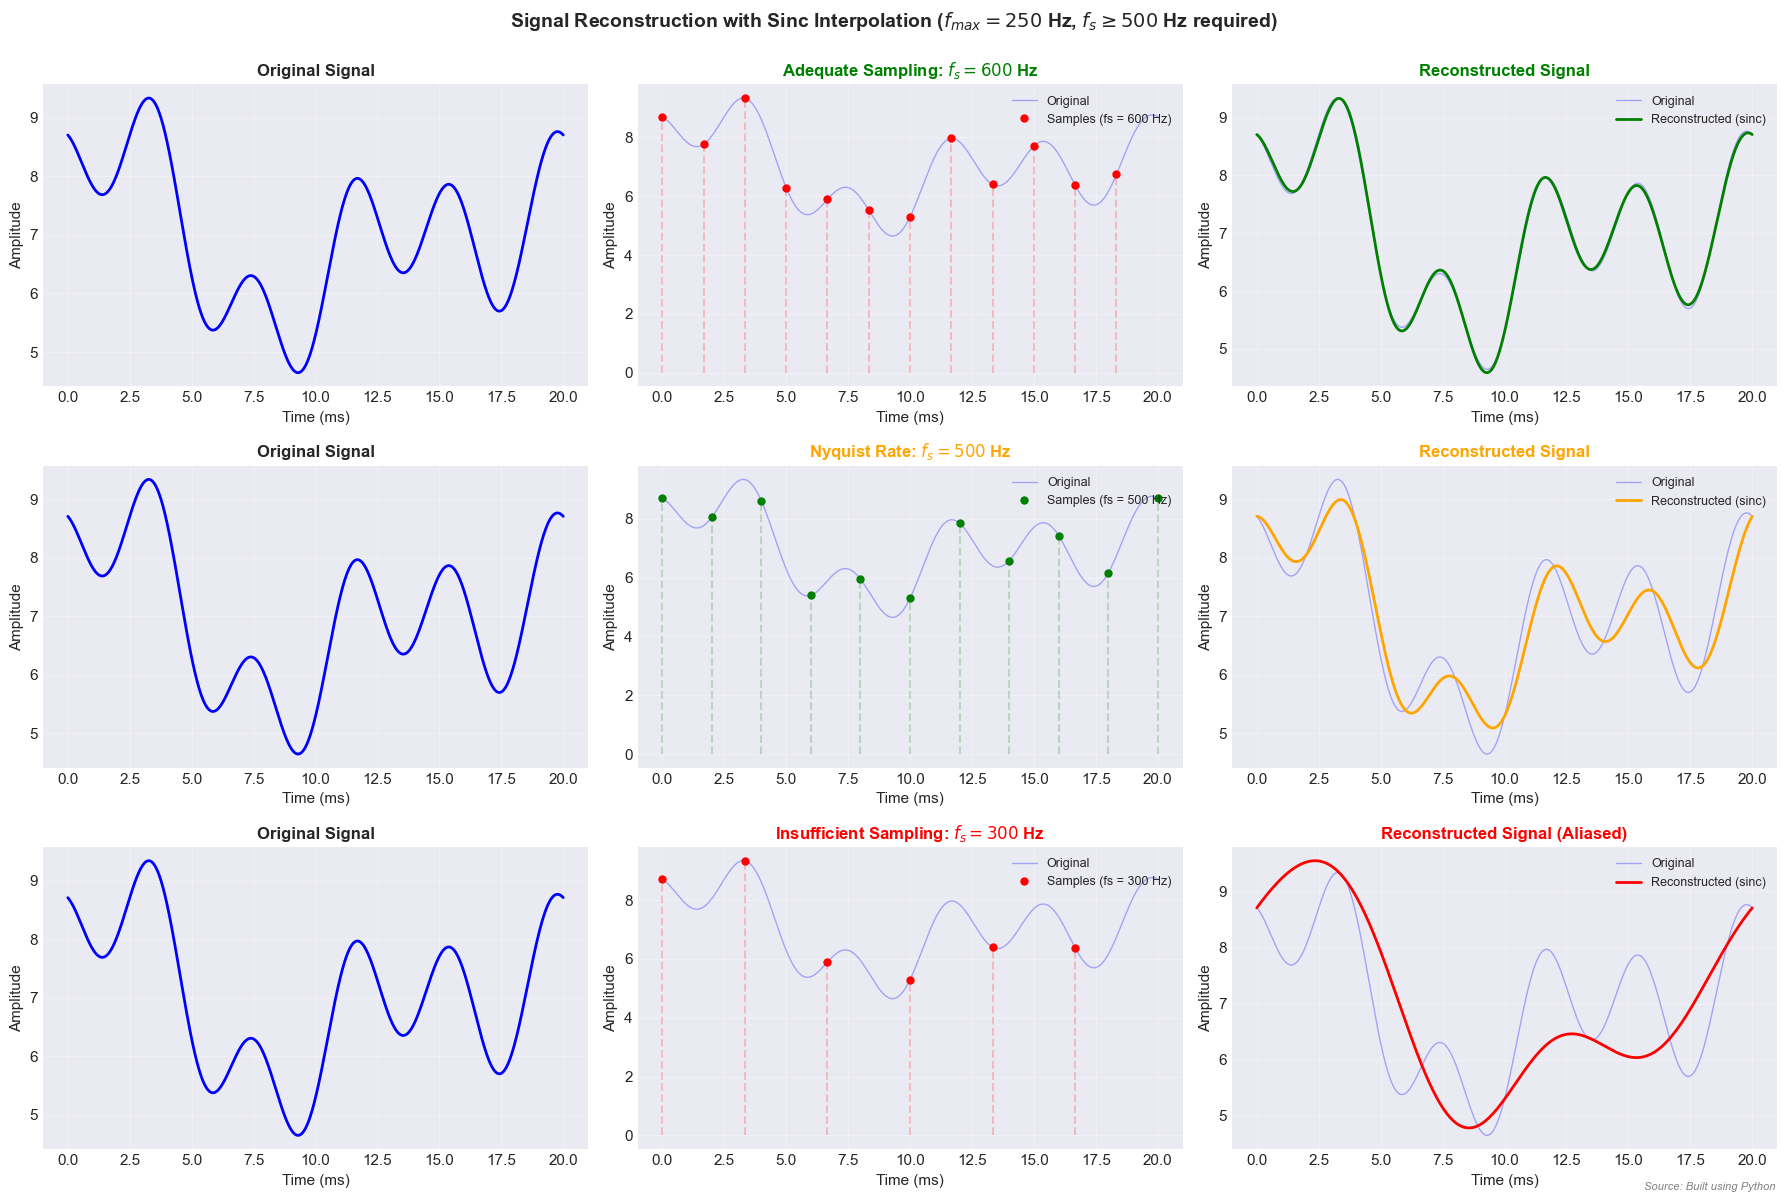

In [13]:
# Define the signal
def x(t):
    return (np.cos(100 * np.pi * t) + 
            np.sin(200 * np.pi * t) + 
            np.cos(500 * np.pi * t + np.pi/4) + 
            7)

# Define sinc function
def sinc(t):
    """Sinc function: sin(πt)/(πt) with sinc(0) = 1"""
    result = np.ones_like(t)
    mask = t != 0
    result[mask] = np.sin(np.pi * t[mask]) / (np.pi * t[mask])
    return result

# Sinc interpolation reconstruction
def sinc_reconstruct(t_reconstruct, t_samples, samples, Ts):
    """
    Reconstruct signal using sinc interpolation
    x(t) = Σ x[n] * sinc((t - nTs)/Ts)
    
    Note: In theory, this requires an infinite sum from -∞ to +∞.
    In practice, we use a finite window which causes edge effects.
    """
    reconstructed = np.zeros_like(t_reconstruct)
    for n, sample in enumerate(samples):
        # Calculate sinc for each sample
        sinc_values = sinc((t_reconstruct - t_samples[n]) / Ts)
        reconstructed += sample * sinc_values
    return reconstructed

# Time range for continuous signal (visible window)
t_continuous = np.linspace(0, 0.02, 10000)  # 0 to 20 ms
signal_continuous = x(t_continuous)

# Sampling rates
fs_adequate = 600  # Above Nyquist (600 > 500)
fs_nyquist = 500   # Exactly Nyquist (500 = 2*250)
fs_insufficient = 300  # Below Nyquist (300 < 500)

# To minimize edge effects, we sample over a wider window with padding
# This provides samples before and after the visible window for better reconstruction
padding = 0.01  # 10 ms padding on each side

# Create figure with subplots: 3 rows (adequate, nyquist, insufficient) x 3 cols (original, sampled, reconstructed)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Row 1: Adequate sampling (with padding to reduce edge effects)
t_samples_adequate = np.arange(-padding, 0.02 + padding, 1/fs_adequate)
samples_adequate = x(t_samples_adequate)
Ts_adequate = 1/fs_adequate
reconstructed_adequate = sinc_reconstruct(t_continuous, t_samples_adequate, samples_adequate, Ts_adequate)

# For display, only show samples within the visible window
visible_mask_adequate = (t_samples_adequate >= 0) & (t_samples_adequate <= 0.02)
t_samples_adequate_visible = t_samples_adequate[visible_mask_adequate]
samples_adequate_visible = samples_adequate[visible_mask_adequate]

# Original
axes[0, 0].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Time (ms)', fontsize=11)
axes[0, 0].set_ylabel('Amplitude', fontsize=11)
axes[0, 0].set_title('Original Signal', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Sampled (display only visible window samples)
axes[0, 1].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[0, 1].plot(t_samples_adequate_visible * 1000, samples_adequate_visible, 'ro', markersize=5, label=f'Samples (fs = {fs_adequate} Hz)')
axes[0, 1].vlines(t_samples_adequate_visible * 1000, 0, samples_adequate_visible, colors='r', linestyles='--', alpha=0.2)
axes[0, 1].set_xlabel('Time (ms)', fontsize=11)
axes[0, 1].set_ylabel('Amplitude', fontsize=11)
axes[0, 1].set_title(f'Adequate Sampling: $f_s = {fs_adequate}$ Hz', fontsize=12, fontweight='bold', color='green')
axes[0, 1].legend(loc='upper right', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Reconstructed
axes[0, 2].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[0, 2].plot(t_continuous * 1000, reconstructed_adequate, 'g-', linewidth=2, label='Reconstructed (sinc)')
axes[0, 2].set_xlabel('Time (ms)', fontsize=11)
axes[0, 2].set_ylabel('Amplitude', fontsize=11)
axes[0, 2].set_title('Reconstructed Signal', fontsize=12, fontweight='bold', color='green')
axes[0, 2].legend(loc='upper right', fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Nyquist rate sampling (with padding)
t_samples_nyquist = np.arange(-padding, 0.02 + padding, 1/fs_nyquist)
samples_nyquist = x(t_samples_nyquist)
Ts_nyquist = 1/fs_nyquist
reconstructed_nyquist = sinc_reconstruct(t_continuous, t_samples_nyquist, samples_nyquist, Ts_nyquist)

visible_mask_nyquist = (t_samples_nyquist >= 0) & (t_samples_nyquist <= 0.02)
t_samples_nyquist_visible = t_samples_nyquist[visible_mask_nyquist]
samples_nyquist_visible = samples_nyquist[visible_mask_nyquist]

# Original
axes[1, 0].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=2)
axes[1, 0].set_xlabel('Time (ms)', fontsize=11)
axes[1, 0].set_ylabel('Amplitude', fontsize=11)
axes[1, 0].set_title('Original Signal', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Sampled (display only visible window samples)
axes[1, 1].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[1, 1].plot(t_samples_nyquist_visible * 1000, samples_nyquist_visible, 'go', markersize=5, label=f'Samples (fs = {fs_nyquist} Hz)')
axes[1, 1].vlines(t_samples_nyquist_visible * 1000, 0, samples_nyquist_visible, colors='g', linestyles='--', alpha=0.2)
axes[1, 1].set_xlabel('Time (ms)', fontsize=11)
axes[1, 1].set_ylabel('Amplitude', fontsize=11)
axes[1, 1].set_title(f'Nyquist Rate: $f_s = {fs_nyquist}$ Hz', fontsize=12, fontweight='bold', color='orange')
axes[1, 1].legend(loc='upper right', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

# Reconstructed
axes[1, 2].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[1, 2].plot(t_continuous * 1000, reconstructed_nyquist, 'orange', linewidth=2, label='Reconstructed (sinc)')
axes[1, 2].set_xlabel('Time (ms)', fontsize=11)
axes[1, 2].set_ylabel('Amplitude', fontsize=11)
axes[1, 2].set_title('Reconstructed Signal', fontsize=12, fontweight='bold', color='orange')
axes[1, 2].legend(loc='upper right', fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

# Row 3: Insufficient sampling (with padding)
t_samples_insufficient = np.arange(-padding, 0.02 + padding, 1/fs_insufficient)
samples_insufficient = x(t_samples_insufficient)
Ts_insufficient = 1/fs_insufficient
reconstructed_insufficient = sinc_reconstruct(t_continuous, t_samples_insufficient, samples_insufficient, Ts_insufficient)

visible_mask_insufficient = (t_samples_insufficient >= 0) & (t_samples_insufficient <= 0.02)
t_samples_insufficient_visible = t_samples_insufficient[visible_mask_insufficient]
samples_insufficient_visible = samples_insufficient[visible_mask_insufficient]

# Original
axes[2, 0].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=2)
axes[2, 0].set_xlabel('Time (ms)', fontsize=11)
axes[2, 0].set_ylabel('Amplitude', fontsize=11)
axes[2, 0].set_title('Original Signal', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# Sampled (display only visible window samples)
axes[2, 1].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[2, 1].plot(t_samples_insufficient_visible * 1000, samples_insufficient_visible, 'ro', markersize=5, label=f'Samples (fs = {fs_insufficient} Hz)')
axes[2, 1].vlines(t_samples_insufficient_visible * 1000, 0, samples_insufficient_visible, colors='r', linestyles='--', alpha=0.2)
axes[2, 1].set_xlabel('Time (ms)', fontsize=11)
axes[2, 1].set_ylabel('Amplitude', fontsize=11)
axes[2, 1].set_title(f'Insufficient Sampling: $f_s = {fs_insufficient}$ Hz', fontsize=12, fontweight='bold', color='red')
axes[2, 1].legend(loc='upper right', fontsize=9)
axes[2, 1].grid(True, alpha=0.3)

# Reconstructed
axes[2, 2].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.3, label='Original')
axes[2, 2].plot(t_continuous * 1000, reconstructed_insufficient, 'r-', linewidth=2, label='Reconstructed (sinc)')
axes[2, 2].set_xlabel('Time (ms)', fontsize=11)
axes[2, 2].set_ylabel('Amplitude', fontsize=11)
axes[2, 2].set_title('Reconstructed Signal (Aliased)', fontsize=12, fontweight='bold', color='red')
axes[2, 2].legend(loc='upper right', fontsize=9)
axes[2, 2].grid(True, alpha=0.3)

# Add overall title
fig.suptitle(f'Signal Reconstruction with Sinc Interpolation ($f_{{max}} = {f_max}$ Hz, $f_s \\geq {f_nyquist}$ Hz required)', 
             fontsize=14, fontweight='bold', y=0.995)

# Add source note at the bottom
fig.text(0.99, 0.01, 'Source: Built using Python', 
         ha='right', va='bottom', fontsize=8, style='italic', color='gray')

plt.tight_layout()
plt.savefig(f'{output_dir}/aliasing_exercise.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/aliasing_exercise.pdf', bbox_inches='tight')
print(f"Saved: {output_dir}/aliasing_exercise.png")
plt.show()


## Note on Practical Sinc Reconstruction

The theoretical sinc interpolation formula requires an **infinite sum** of samples:

$$x(t) = \sum_{n=-\infty}^{\infty} x[n] \cdot \text{sinc}\left(\frac{t - nT_s}{T_s}\right)$$

However, in practice we face several limitations:

1. **Finite time window**: We can only sample over a finite interval (e.g., 0 to 20 ms), not from $-\infty$ to $+\infty$
2. **Boundary effects**: Near the edges of the window, there aren't enough samples on both sides for perfect reconstruction
3. **Truncation**: Each sinc function extends infinitely, but we only sum over available samples

To minimize these edge effects, we use **padding** by sampling beyond the visible window. This provides additional samples that help reconstruct the signal more accurately near the boundaries.
